In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import gridspec
import seaborn as sns
import matplotlib.patches as patches
import anndata as ad
import scanpy as sc
import scvi
import torch
import scipy.sparse as sp
from scipy.stats import hypergeom

# import cellspec as spc

%matplotlib inline

/home/dmullane/micromamba/envs/scvi-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# TODO (things to try)

### QC

- ☑ Gene Length Normalization (may or may not implement, try each integration with and without)
- ☐ Mitochondrial Reads
- ☐ Doublet detection

### Normalization and imputation
- ☐ MAGIC
- ☐ SCRAN

### Feature selection
- ☒ scVI probabilistic
- ☐ seurat style `flavor="seurat_v3"`


### Integration
- ☒ Ingest
- ☐ bbknn
- ☐ mnn
- ☐ harmony
- ☐ scanorama
- ☒ scVI
- ☐ symphony

### Label Transfer
- ☒ scANVI
- ☐ scTypist
- ☐ symphony



# basic RNA analysis

In [2]:
csvs = {
    'UDI_5':'../results/worm_CapGTA_UDI_5/rna_counts_matrix.csv',
    'UDI_6':'../results/worm_CapGTA_UDI_5/rna_counts_matrix.csv',
    'UDI_7':'../results/worm_CapGTA_UDI_5/rna_counts_matrix.csv',
    'UDI_8':'../results/worm_CapGTA_UDI_5/rna_counts_matrix.csv',
}

adatas = []

for batch_id,csv in csvs.items():
    df = pd.read_csv(csv, index_col=0)

    # AnnData expects cells x genes, so transpose
    adata = ad.AnnData(X=df.T.values)
    adata.obs_names = [f"{bc}_{batch_id}" for bc in df.columns]   # cell barcodes
    adata.var_names = df.index.tolist()
    adata.obs['UDI'] = batch_id

    adatas.append(adata)
    
rna_ad = ad.concat(adatas)
rna_ad

AnnData object with n_obs × n_vars = 4000 × 46748
    obs: 'UDI'

Text(0, 0.5, 'Count of Cells')

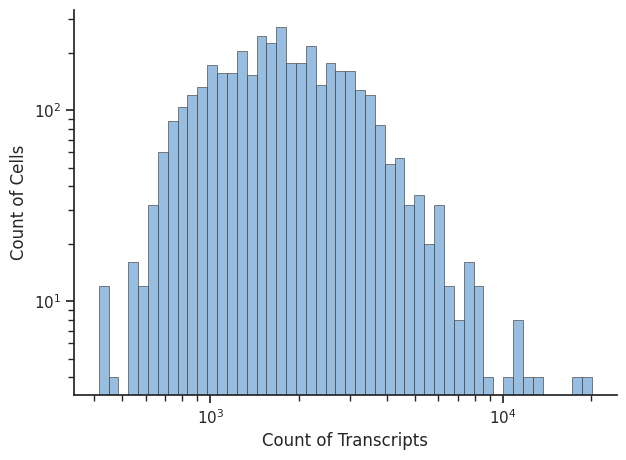

In [3]:
sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)
sns.histplot(rna_ad.X.sum(axis=1), 
             alpha=0.5,
             color = '#317EC2',
             edgecolor=".3",
             linewidth=.5,
             ax=ax,
             log_scale=True,
             bins=50
            )
ax.set_yscale('log')
plt.xlabel("Count of Transcripts", fontsize=12)
plt.ylabel("Count of Cells", fontsize=12)


In [4]:
rna_ad.X.sum(axis=1).mean()

np.float64(2141.739)

### Add gene annotations

In [5]:
gene_len = pd.read_csv('../data/reference/gene_lengths.csv', index_col=0)
gene_len = gene_len.reindex(rna_ad.var.index).dropna()
gene_len#['chromosome']=='MtDNA'

,gene_name,chromosome,exonic_length,num_exons,num_merged_exons
WBGene00023193,Y74C9A.6,I,163,1,1
WBGene00022277,homt-1,I,889,5,5
WBGene00022276,nlp-40,I,893,27,5
WBGene00022278,rcor-1,I,2126,42,12
WBGene00235381,Y74C9A.9,I,719,1,1
...,...,...,...,...,...
WBGene00017625,cgt-2,X,1742,7,7
WBGene00219677,anr-17,X,108,1,1
WBGene00019189,H11L12.1,X,759,5,5
WBGene00007069,6R55.2,X,296,2,2


In [6]:
rna_ad.var[['gene_name','chromosome','exonic_length','num_exons','num_merged_exons']] = gene_len
rna_ad.var

,gene_name,chromosome,exonic_length,num_exons,num_merged_exons
WBGene00023193,Y74C9A.6,I,163,1,1
WBGene00022277,homt-1,I,889,5,5
WBGene00022276,nlp-40,I,893,27,5
WBGene00022278,rcor-1,I,2126,42,12
WBGene00235381,Y74C9A.9,I,719,1,1
...,...,...,...,...,...
WBGene00017625,cgt-2,X,1742,7,7
WBGene00219677,anr-17,X,108,1,1
WBGene00019189,H11L12.1,X,759,5,5
WBGene00007069,6R55.2,X,296,2,2


### Normalize counts by gene length

* TBD If this is good 

In [7]:
# gene_len = gene_len.reindex(rna_ad.var.index).dropna()
# rna_ad = rna_ad[:, gene_len.index]
# assert (rna_ad.var.index == gene_len.index).sum() == rna_ad.shape[1]
# rna_ad.X = (rna_ad.X / gene_len['exonic_length'].values) * np.median(gene_len['exonic_length'].values)
# # round to integer
# rna_ad.X = np.rint(rna_ad.X)

In [8]:
# sns.set_theme(style="ticks")
# f, ax = plt.subplots(figsize=(7, 5))
# sns.despine(f)
# sns.histplot(rna_ad.X.sum(axis=1), 
#              alpha=0.5,
#              color = '#317EC2',
#              edgecolor=".3",
#              linewidth=.5,
#              ax=ax,
#              log_scale=True,
#              bins=50
#             )
# ax.set_yscale('log')
# plt.xlabel("Length Normalized Count of Transcripts", fontsize=12)
# plt.ylabel("Count of Cells", fontsize=12)


In [9]:
# rna_ad.X.sum(axis=1).mean()

### QC

In [10]:
rna_ad.var["mt"] = rna_ad.var['chromosome']=="MtDNA"

In [11]:
sc.pp.calculate_qc_metrics(rna_ad, qc_vars=["mt"], inplace=True)

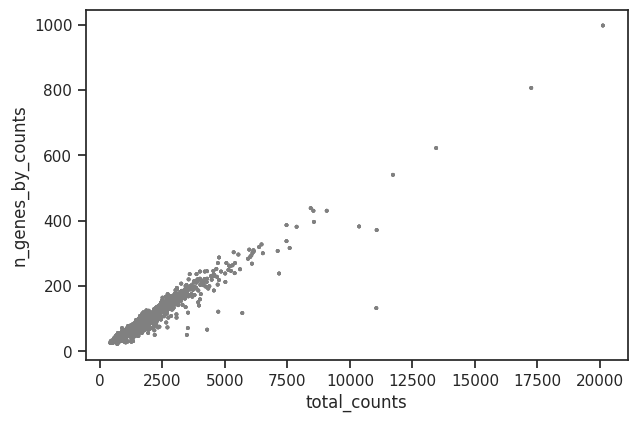

In [12]:
sc.pl.scatter(rna_ad, "total_counts", "n_genes_by_counts")

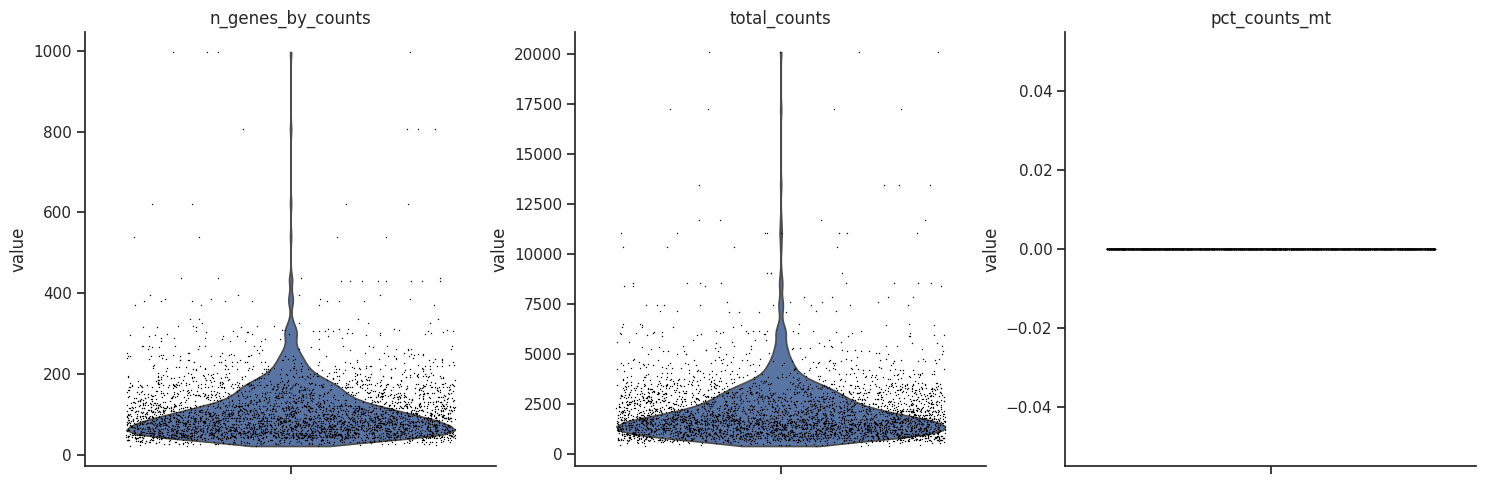

In [13]:
sc.pl.violin(
    rna_ad,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

### Doublet detection

In [14]:
sc.pp.scrublet(rna_ad)

### Normalization

In [15]:
rna_ad.layers["counts"] = rna_ad.X

In [16]:
# Normalizing to median total counts
sc.pp.normalize_total(rna_ad)
# Logarithmize the data
sc.pp.log1p(rna_ad)

### Feature selection

In [66]:
sc.pl.highly_variable_genes?

Signature:
sc.pl.highly_variable_genes(
    adata_or_result: 'AnnData | pd.DataFrame | np.recarray',
    *,
    log: 'bool' = False,
    show: 'bool | None' = None,
    save: 'bool | str | None' = None,
    highly_variable_genes: 'bool' = True,
) -> 'None'
Docstring:
Plot dispersions or normalized variance versus means for genes.

Produces Supp. Fig. 5c of Zheng et al. (2017) and MeanVarPlot() and
VariableFeaturePlot() of Seurat.

Parameters
----------
adata
    Result of :func:`~scanpy.pp.highly_variable_genes`.
log : 'bool', optional (default: False)
    Plot on logarithmic axes.
show : 'bool | None', optional (default: None)
     Show the plot, do not return axis.
save : 'bool | str | None', optional (default: None)
    If `True` or a `str`, save the figure.
    A string is appended to the default filename.
    Infer the filetype if ending on {{`'.pdf'`, `'.png'`, `'.svg'`}}.
File:      ~/micromamba/envs/scvi-env/lib/python3.11/site-packages/scanpy/plotting/_preprocessing.py
Type:  

/home/dmullane/micromamba/envs/scvi-env/lib/python3.11/site-packages/legacy_api_wrap/__init__.py:88: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)


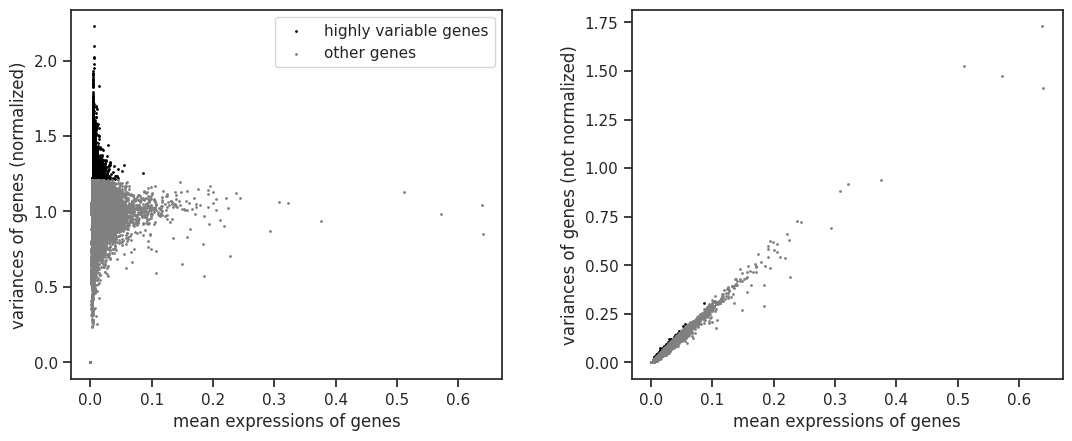

In [17]:
sc.pp.highly_variable_genes(rna_ad, flavor='seurat_v3')
sc.pl.highly_variable_genes(rna_ad)


In [18]:
sc.pp.highly_variable_genes(rna_ad, flavor='seurat_v3', subset=True)

/home/dmullane/micromamba/envs/scvi-env/lib/python3.11/site-packages/legacy_api_wrap/__init__.py:88: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)


### Basic analysis

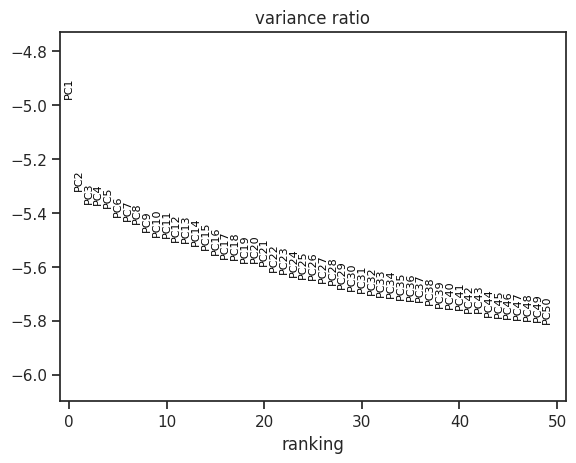

In [19]:
sc.tl.pca(rna_ad, n_comps=50)
sc.pl.pca_variance_ratio(rna_ad, n_pcs=50, log=True)

In [20]:
sc.pp.neighbors(rna_ad)
sc.tl.umap(rna_ad)

/home/dmullane/micromamba/envs/scvi-env/lib/python3.11/site-packages/scipy/sparse/_index.py:216: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


In [21]:
sc.tl.leiden(rna_ad, resolution=1, key_added='leiden_1')
sc.tl.leiden(rna_ad, resolution=1.5, key_added='leiden_1.5')
sc.tl.leiden(rna_ad, resolution=2, key_added='leiden_2')
sc.tl.leiden(rna_ad, resolution=2.5, key_added='leiden_2.5')
sc.tl.leiden(rna_ad, resolution=3, key_added='leiden_3')

/loc/scratch/47826056/ipykernel_16275/2566549529.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(rna_ad, resolution=1, key_added='leiden_1')


In [22]:
print(len(rna_ad.obs['leiden_1'].unique()))
print(len(rna_ad.obs['leiden_1.5'].unique()))
print(len(rna_ad.obs['leiden_2'].unique()))
print(len(rna_ad.obs['leiden_2.5'].unique()))
print(len(rna_ad.obs['leiden_3'].unique()))

88
101
110
117
120


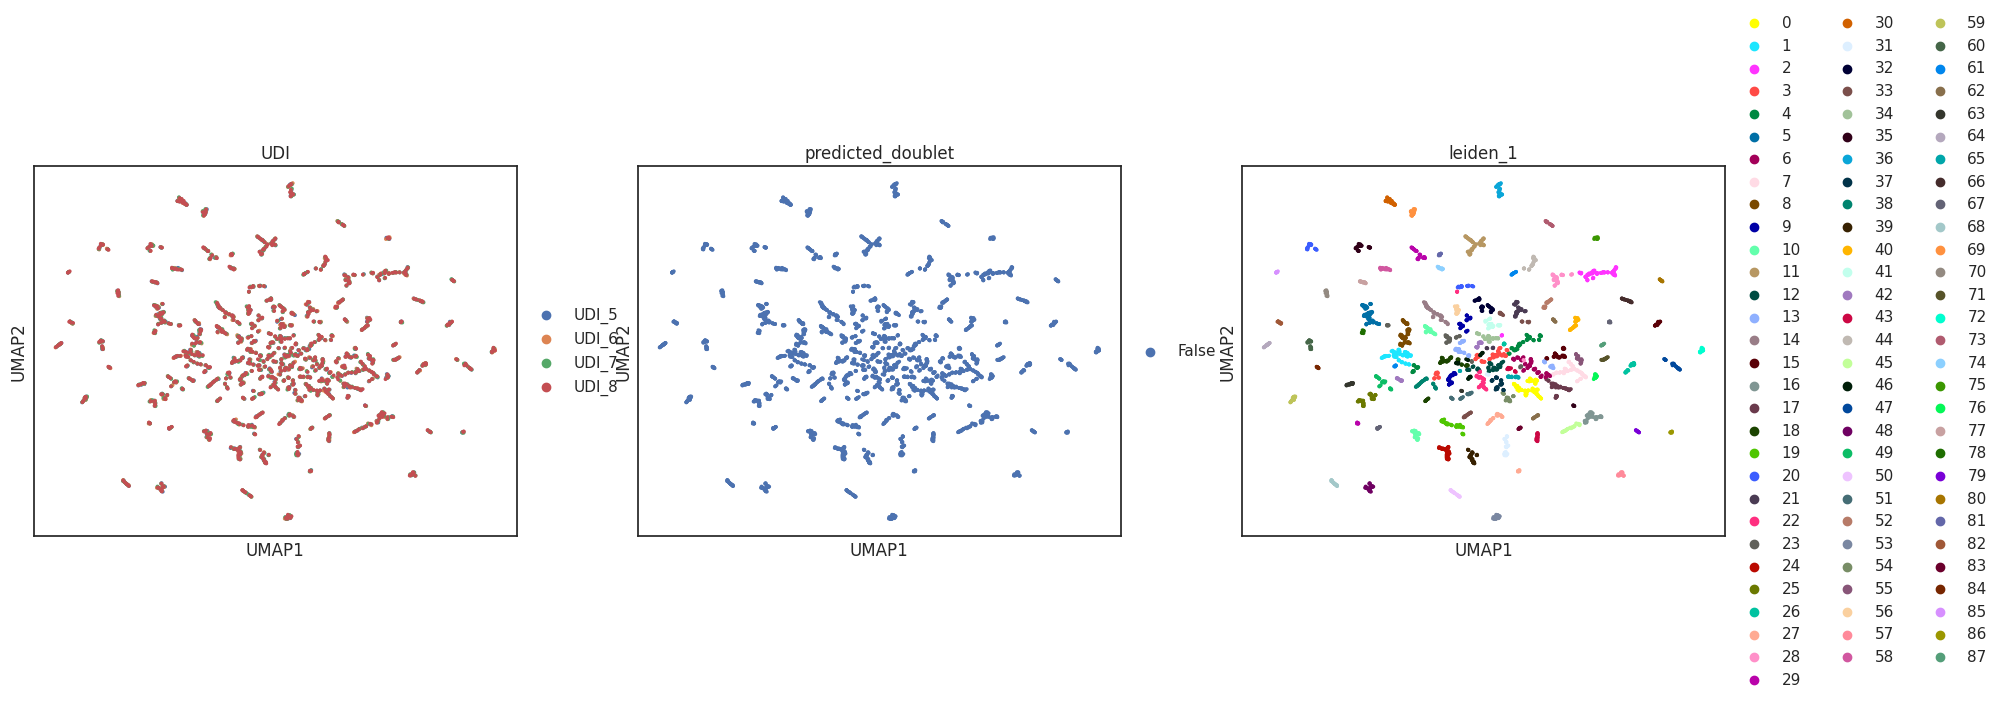

In [23]:
sc.pl.umap(
    rna_ad,
    color=['UDI','predicted_doublet','leiden_1']
)

In [24]:
sc.tl.rank_genes_groups(rna_ad, groupby="leiden_1", method="wilcoxon", key_added="rank_genes_groups_leiden_1")

sc.tl.rank_genes_groups(rna_ad, groupby="leiden_1.5", method="wilcoxon", key_added="rank_genes_groups_leiden_1.5")

sc.tl.rank_genes_groups(rna_ad, groupby="leiden_2", method="wilcoxon", key_added="rank_genes_groups_leiden_2")

sc.tl.rank_genes_groups(rna_ad, groupby="leiden_2.5", method="wilcoxon", key_added="rank_genes_groups_leiden_2.5")

sc.tl.rank_genes_groups(rna_ad, groupby="leiden_3", method="wilcoxon", key_added="rank_genes_groups_leiden_3")


/home/dmullane/micromamba/envs/scvi-env/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:458: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/home/dmullane/micromamba/envs/scvi-env/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:460: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/home/dmullane/micromamba/envs/scvi-env/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.

# Basic Analysis of Wormseq

In [25]:
# ref_ad = sc.read_h5ad('../data/reference/Ghaddar2023/cds_baseline_post_sub.h5ad')
ref_ad = sc.read_h5ad('../data/reference/Ghaddar2023/cds_baseline_with_counts.h5ad')
ref_ad

AnnData object with n_obs × n_vars = 154251 × 20222
    obs: 'cell', 'n.umi', 'umi.quant', 'condition', 'channel', 'Size_Factor', 'num_genes_expressed', 'bg.counts.YA.C.loadings', 'bg.counts.YA.F.loadings', 'sample', 'bg.counts.YA.C.1', 'bg.counts.YA.C.2', 'bg.counts.YA.C.3', 'bg.counts.YA.F.1', 'bg.counts.YA.F.2', 'bg.counts.YA.F.3', 'cluster', 'assigned_cell_type', 'cell_type_group'
    var: 'id', 'gene_short_name', 'num_cells_expressed', 'use_for_ordering'
    uns: 'X_name', 'cds_version', 'citations'
    obsm: 'Aligned', 'PCA', 'UMAP'
    layers: 'counts'

In [26]:
## subset to genes present in our data:
var_names = ref_ad.var_names.intersection(rna_ad.var_names)
ref_ad = ref_ad[:, var_names].copy()
rna_ad = rna_ad[:, var_names].copy()

In [27]:
## Remove cells not present in query data
ref_ad = ref_ad[ref_ad.obs['cell_type_group'] != 'Germline'].copy()

In [28]:
# Normalizing to median total counts
sc.pp.normalize_total(ref_ad)
# Logarithmize the data
sc.pp.log1p(ref_ad)

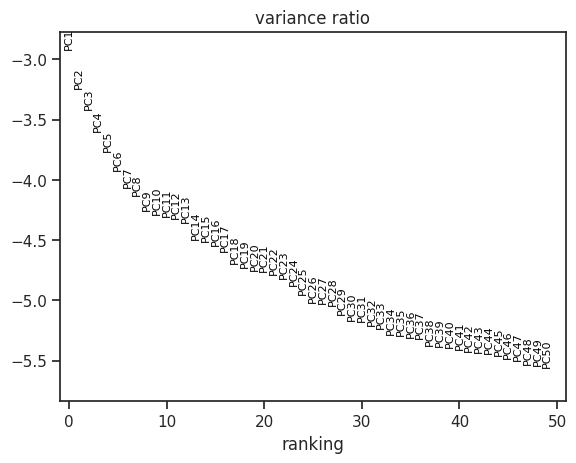

In [29]:
sc.tl.pca(ref_ad, n_comps=50)
sc.pl.pca_variance_ratio(ref_ad, n_pcs=50, log=True)

In [30]:
sc.pp.neighbors(ref_ad)
sc.tl.umap(ref_ad)

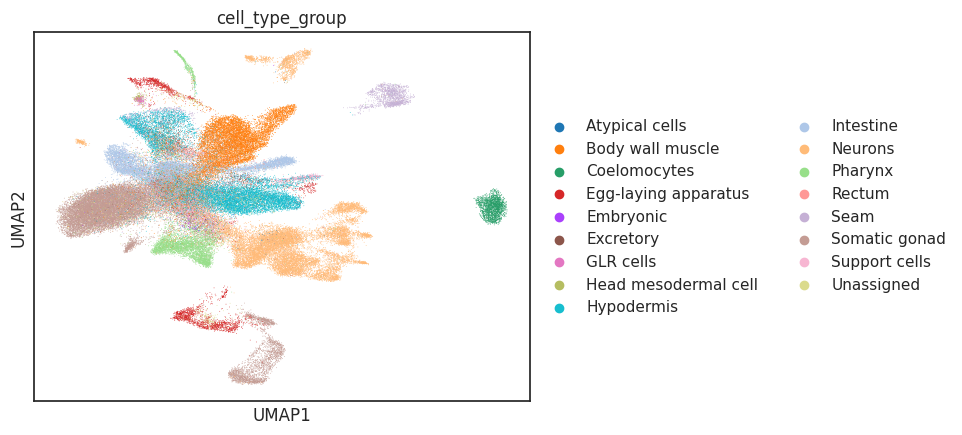

In [31]:
sc.pl.umap(
    ref_ad,
    color=['cell_type_group']
)

In [32]:
# Obtain cluster-specific differentially expressed genes
sc.tl.rank_genes_groups(ref_ad, groupby="assigned_cell_type", method="wilcoxon")

/home/dmullane/micromamba/envs/scvi-env/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:458: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/home/dmullane/micromamba/envs/scvi-env/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:460: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/home/dmullane/micromamba/envs/scvi-env/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.

# Cell type classification by overlapping DEGs

In [33]:
def get_deg_dict(adata, groupby, n_genes=50, key="rank_genes_groups"):
    """Extract top DEGs per cluster as a dictionary."""
    deg_dict = {}
    groups = adata.obs[groupby].unique()
    for g in groups:
        genes = sc.get.rank_genes_groups_df(adata, group=str(g), key=key)
        genes = genes[genes["logfoldchanges"] > 0].head(n_genes)["names"].tolist()
        deg_dict[str(g)] = set(genes)
    return deg_dict

def compute_overlap_scores(query_degs, ref_degs, all_genes_n):
    """
    Compute Jaccard and -log10(hypergeometric p-value) for all 
    query x ref cluster pairs. Returns both matrices.
    """
    q_clusters = list(query_degs.keys())
    r_clusters = list(ref_degs.keys())
    
    jaccard_mat = pd.DataFrame(index=q_clusters, columns=r_clusters, dtype=float)
    pval_mat    = pd.DataFrame(index=q_clusters, columns=r_clusters, dtype=float)
    
    for q in q_clusters:
        for r in r_clusters:
            q_genes = query_degs[q]
            r_genes = ref_degs[r]
            
            k = len(q_genes & r_genes)
            union = len(q_genes | r_genes)
            
            # jaccard
            jaccard_mat.loc[q, r] = k / union if union > 0 else 0
            
            # hypergeometric
            M = all_genes_n
            n = len(r_genes)
            N = len(q_genes)
            pval = hypergeom.sf(k - 1, M, n, N)
            pval_mat.loc[q, r] = -np.log10(pval + 1e-300)
    
    return jaccard_mat, pval_mat

def match_clusters(query_degs, ref_degs, all_genes_n, top_n=3, metric="hypergeom"):
    """
    For each query cluster, find best matching reference clusters.
    metric: 'hypergeom' (default, recommended for sparse data) or 'jaccard'
    """
    assert metric in ("hypergeom", "jaccard"), "metric must be 'hypergeom' or 'jaccard'"
    
    jaccard_mat, pval_mat = compute_overlap_scores(query_degs, ref_degs, all_genes_n)
    score_mat = pval_mat if metric == "hypergeom" else jaccard_mat
    
    results = []
    for q_cluster in query_degs:
        q_genes = query_degs[q_cluster]
        rows = []
        for r_cluster in ref_degs:
            k        = len(q_genes & ref_degs[r_cluster])
            jaccard  = jaccard_mat.loc[q_cluster, r_cluster]
            logpval  = pval_mat.loc[q_cluster, r_cluster]
            rows.append((r_cluster, jaccard, k, logpval))
        
        scores_df = pd.DataFrame(rows, columns=["ref_cluster", "jaccard", "overlap_n", "neg_log10_pval"])
        scores_df = scores_df.sort_values(metric if metric == "jaccard" else "neg_log10_pval", 
                                          ascending=False)
        best = scores_df.iloc[0]
        results.append({
            "query_cluster":  q_cluster,
            "best_match":     best["ref_cluster"],
            "jaccard":        best["jaccard"],
            "overlap_n":      best["overlap_n"],
            "neg_log10_pval": best["neg_log10_pval"],
            "top_matches":    scores_df.head(top_n)[["ref_cluster", "jaccard", "overlap_n", "neg_log10_pval"]].to_dict("records")
        })
    
    results_df = pd.DataFrame(results).sort_values("query_cluster")
    return results_df, jaccard_mat, pval_mat


def plot_overlap_heatmap(mat, results, title="Cluster overlap", figsize=(16, 6), vmin=None, vmax=None):
    results_sorted = results.sort_values("best_match")
    row_order = results_sorted["query_cluster"].tolist()
    
    # deduplicate while preserving order
    seen = set()
    best_matches_ordered = []
    for m in results_sorted["best_match"].tolist():
        if m not in seen:
            best_matches_ordered.append(m)
            seen.add(m)
    
    remaining = [c for c in mat.columns if c not in seen]
    col_order = best_matches_ordered + remaining

    mat_reordered = mat.loc[row_order, col_order]

    plt.figure(figsize=figsize)
    sns.heatmap(mat_reordered.astype(float), cmap="viridis",
                vmin=vmin, vmax=vmax,
                xticklabels=True, yticklabels=True)
    plt.title(title)
    plt.xlabel("Reference Groups")
    plt.ylabel("Query Groups")
    plt.tight_layout()
    plt.show()

    return mat_reordered

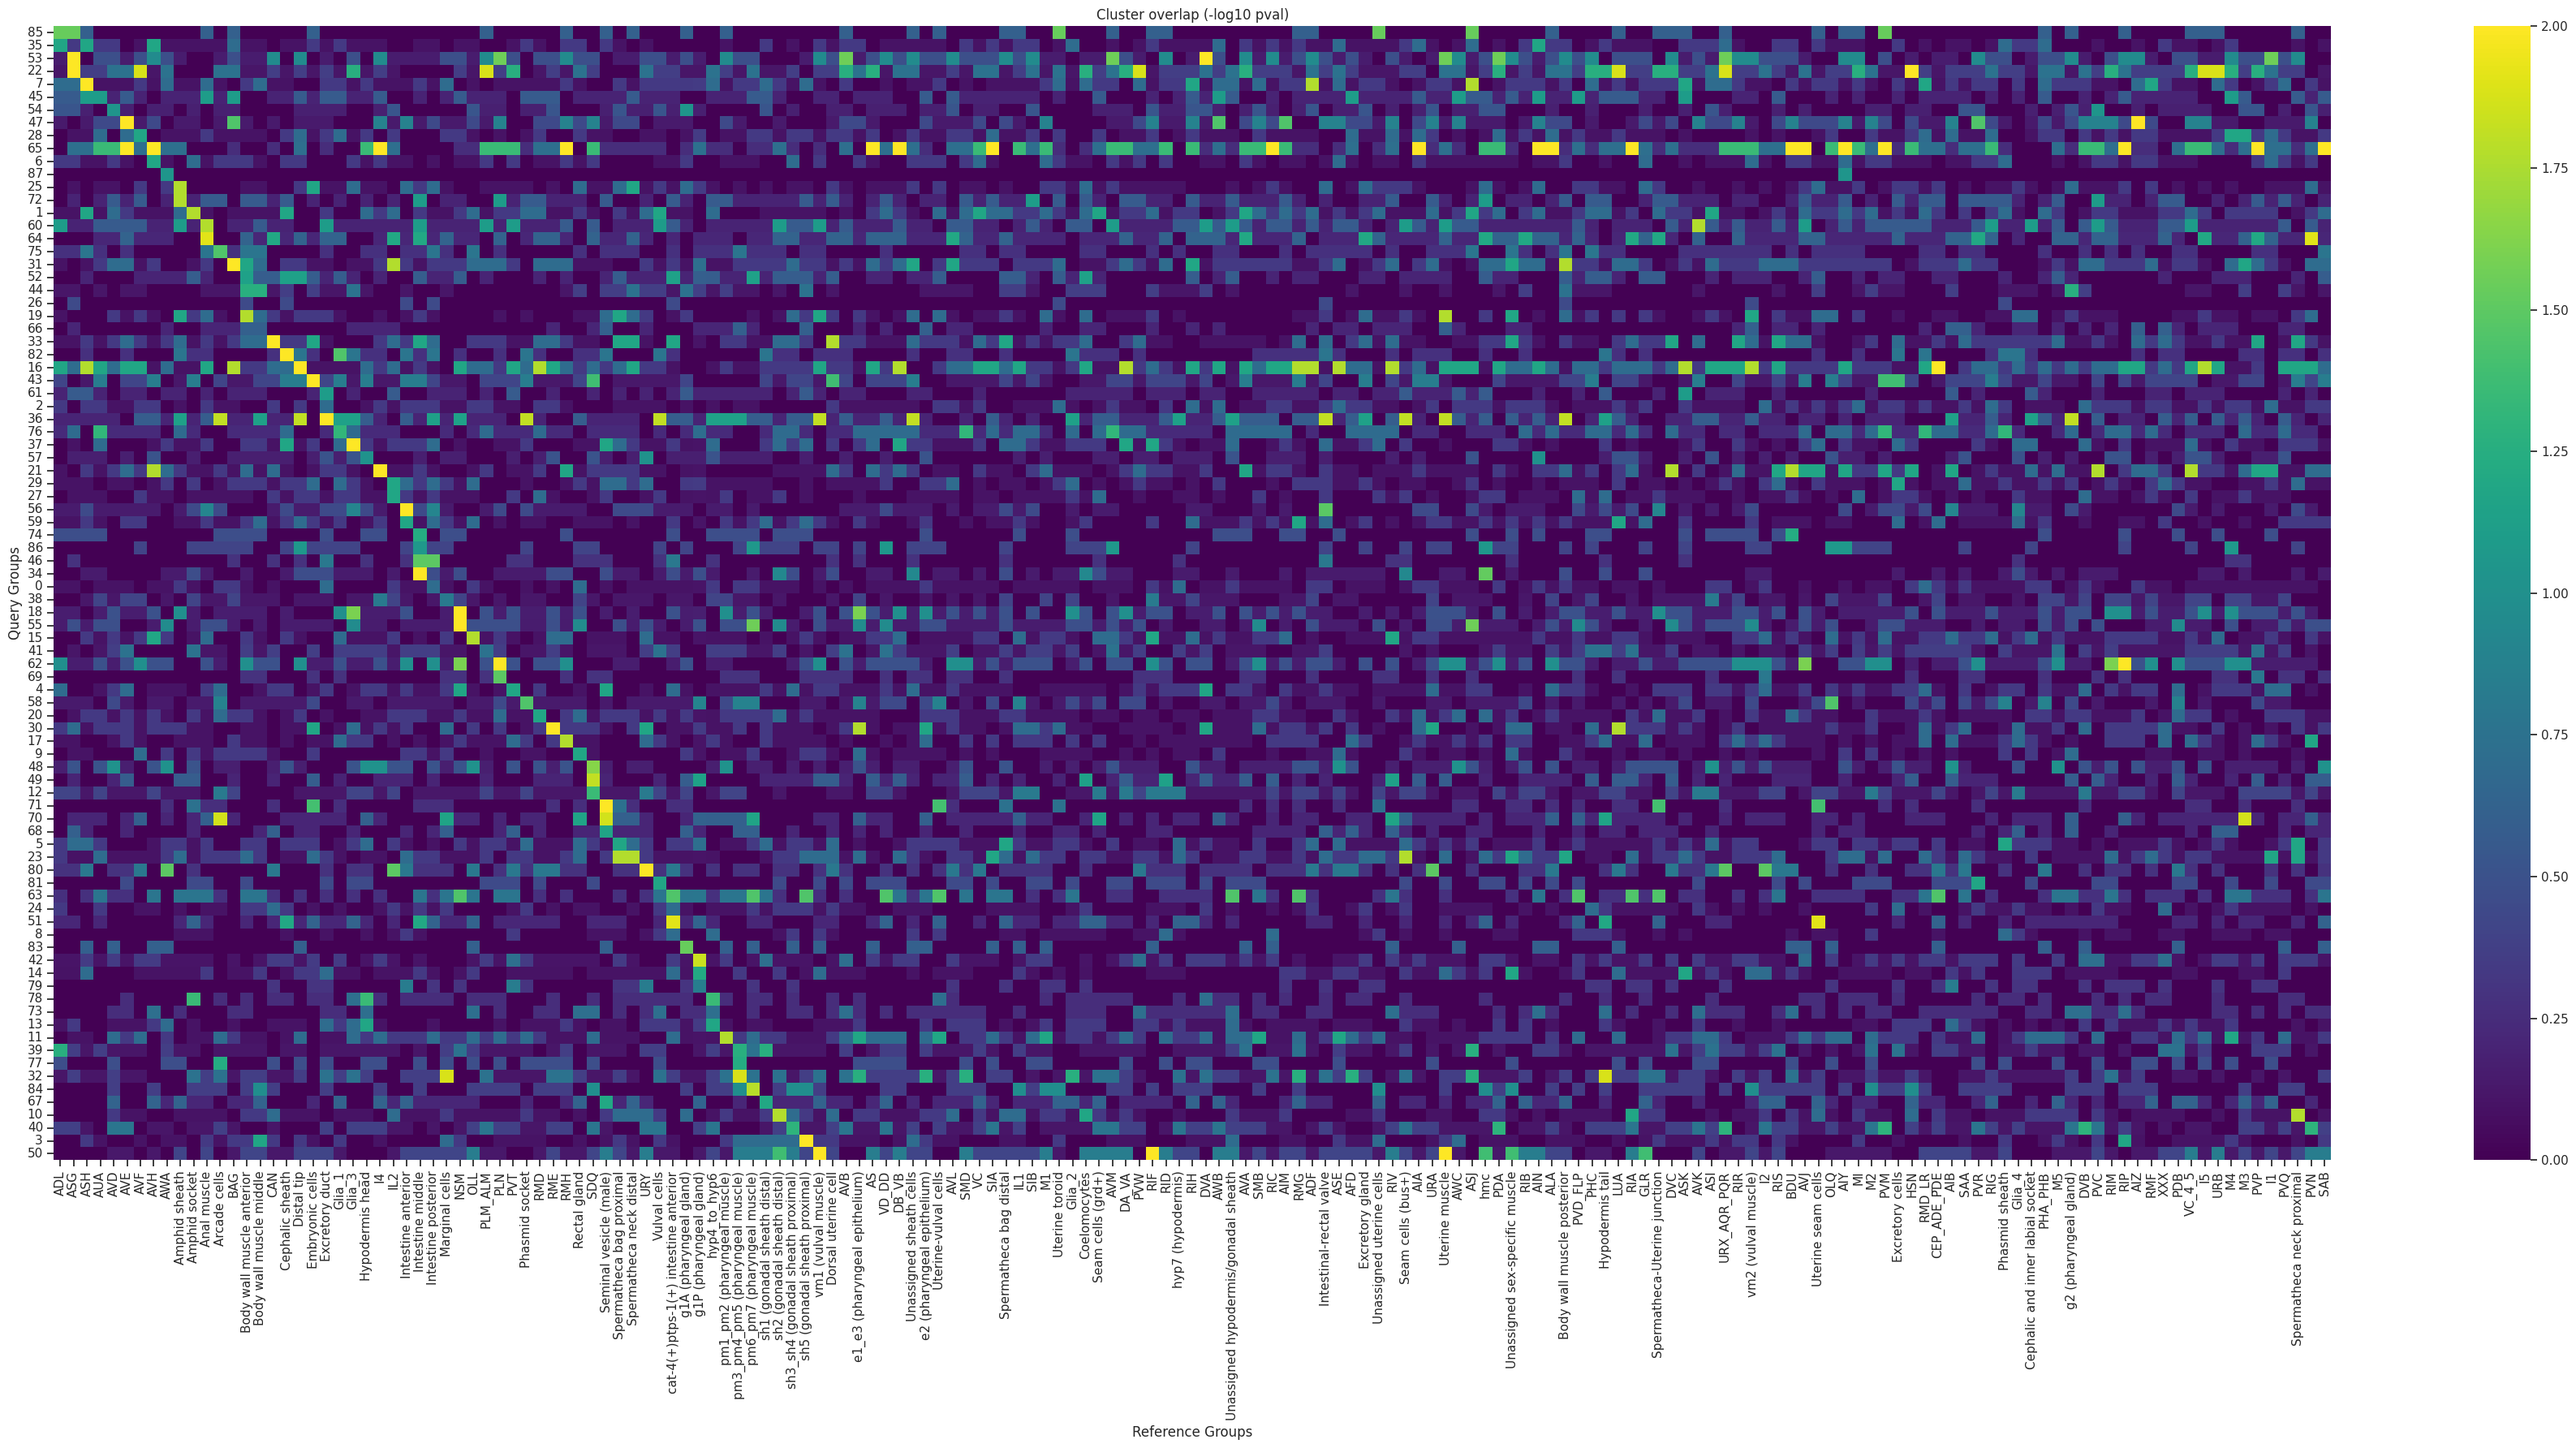

,ADL,ASG,ASH,AUA,AVD,AVE,AVF,AVH,AWA,Amphid sheath,...,I5,URB,M4,M3,PVP,I1,PVQ,Spermatheca neck proximal,PVN,SAB
85,1.532138,1.532138,0.607688,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,...,0.607688,0.607688,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.607688,-0.000000,-0.000000
35,1.183544,0.334409,1.183544,0.334409,0.334409,-0.000000,0.098473,1.183544,0.098473,0.098473,...,-0.000000,0.098473,0.334409,-0.000000,-0.000000,-0.000000,-0.000000,0.098473,-0.000000,0.098473
53,0.154218,2.271187,-0.000000,0.481584,0.481584,0.154218,0.481584,0.958005,0.481584,0.154218,...,0.154218,0.154218,0.958005,0.481584,0.481584,1.560313,0.481584,0.958005,-0.000000,-0.000000
22,0.109901,2.580640,0.365529,0.365529,0.756440,0.756440,1.877204,0.109901,0.756440,-0.000000,...,1.877204,1.877204,1.265288,0.365529,1.265288,0.756440,0.365529,0.365529,-0.000000,0.109901
7,0.701253,0.701253,2.441230,0.098473,0.098473,0.098473,0.334409,0.098473,0.701253,0.098473,...,-0.000000,0.701253,0.334409,-0.000000,0.098473,0.334409,0.701253,-0.000000,0.334409,0.098473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,-0.000000,-0.000000,-0.000000,-0.000000,0.625579,-0.000000,-0.000000,0.625579,0.212088,0.625579,...,0.212088,-0.000000,0.212088,0.625579,0.212088,0.625579,-0.000000,-0.000000,0.212088,-0.000000
10,-0.000000,-0.000000,-0.000000,-0.000000,0.334409,0.098473,0.098473,-0.000000,-0.000000,0.098473,...,-0.000000,0.098473,-0.000000,0.334409,0.098473,0.098473,0.098473,1.767254,-0.000000,0.098473
40,0.376638,0.376638,0.114031,-0.000000,0.776005,0.776005,-0.000000,0.114031,0.114031,-0.000000,...,0.114031,-0.000000,-0.000000,0.376638,0.376638,0.114031,0.376638,0.114031,1.294155,0.376638
3,-0.000000,-0.000000,0.334409,0.098473,-0.000000,-0.000000,0.098473,-0.000000,0.098473,0.098473,...,0.098473,0.098473,0.334409,0.098473,-0.000000,-0.000000,-0.000000,0.098473,-0.000000,0.334409


In [34]:
query_degs = get_deg_dict(rna_ad, groupby="leiden_1", key="rank_genes_groups_leiden_1", n_genes=50)
ref_degs   = get_deg_dict(ref_ad,   groupby="assigned_cell_type", n_genes=50)

# gene universe = genes present in both
shared_genes = len(set(rna_ad.var_names) & set(ref_ad.var_names))

results = match_clusters(query_degs, ref_degs, all_genes_n=shared_genes)

shared_genes = len(set(rna_ad.var_names) & set(ref_ad.var_names))

results, jaccard_mat, pval_mat = match_clusters(
    query_degs, ref_degs, 
    all_genes_n=shared_genes, 
    metric="hypergeom"   # or "jaccard"
)

# plot whichever matrix you want
plot_overlap_heatmap(pval_mat, results, title="Cluster overlap (-log10 pval)", figsize=(36, 18), vmin=0, vmax=2)

In [35]:
# query_degs = get_deg_dict(rna_ad, groupby="leiden_1.5", key="rank_genes_groups_leiden_1.5", n_genes=50)
# ref_degs   = get_deg_dict(ref_ad,   groupby="assigned_cell_type", n_genes=50)

# # gene universe = genes present in both
# shared_genes = len(set(rna_ad.var_names) & set(ref_ad.var_names))

# results = match_clusters(query_degs, ref_degs, all_genes_n=shared_genes)

# shared_genes = len(set(rna_ad.var_names) & set(ref_ad.var_names))

# results, jaccard_mat, pval_mat = match_clusters(
#     query_degs, ref_degs, 
#     all_genes_n=shared_genes, 
#     metric="hypergeom"   # or "jaccard"
# )

# # plot whichever matrix you want
# plot_overlap_heatmap(pval_mat, results, title="Cluster overlap (-log10 pval)", figsize=(36, 18), vmin=0, vmax=2)

In [36]:
# query_degs = get_deg_dict(rna_ad, groupby="leiden_2", key="rank_genes_groups_leiden_2", n_genes=50)
# ref_degs   = get_deg_dict(ref_ad,   groupby="assigned_cell_type", n_genes=50)

# # gene universe = genes present in both
# shared_genes = len(set(rna_ad.var_names) & set(ref_ad.var_names))

# results = match_clusters(query_degs, ref_degs, all_genes_n=shared_genes)

# shared_genes = len(set(rna_ad.var_names) & set(ref_ad.var_names))

# results, jaccard_mat, pval_mat = match_clusters(
#     query_degs, ref_degs, 
#     all_genes_n=shared_genes, 
#     metric="hypergeom"   # or "jaccard"
# )

# # plot whichever matrix you want
# plot_overlap_heatmap(pval_mat, results, title="Cluster overlap (-log10 pval)", figsize=(36, 18), vmin=0, vmax=2)

In [37]:
# query_degs = get_deg_dict(rna_ad, groupby="leiden_2.5", key="rank_genes_groups_leiden_2.5", n_genes=50)
# ref_degs   = get_deg_dict(ref_ad,   groupby="assigned_cell_type", n_genes=50)

# # gene universe = genes present in both
# shared_genes = len(set(rna_ad.var_names) & set(ref_ad.var_names))

# results = match_clusters(query_degs, ref_degs, all_genes_n=shared_genes)

# shared_genes = len(set(rna_ad.var_names) & set(ref_ad.var_names))

# results, jaccard_mat, pval_mat = match_clusters(
#     query_degs, ref_degs, 
#     all_genes_n=shared_genes, 
#     metric="hypergeom"   # or "jaccard"
# )

# # plot whichever matrix you want
# plot_overlap_heatmap(pval_mat, results, title="Cluster overlap (-log10 pval)", figsize=(36, 18), vmin=0, vmax=2)

In [38]:
# query_degs = get_deg_dict(rna_ad, groupby="leiden_3", key="rank_genes_groups_leiden_3", n_genes=50)
# ref_degs   = get_deg_dict(ref_ad,   groupby="assigned_cell_type", n_genes=50)

# # gene universe = genes present in both
# shared_genes = len(set(rna_ad.var_names) & set(ref_ad.var_names))

# results = match_clusters(query_degs, ref_degs, all_genes_n=shared_genes)

# shared_genes = len(set(rna_ad.var_names) & set(ref_ad.var_names))

# results, jaccard_mat, pval_mat = match_clusters(
#     query_degs, ref_degs, 
#     all_genes_n=shared_genes, 
#     metric="hypergeom"   # or "jaccard"
# )

# # plot whichever matrix you want
# plot_overlap_heatmap(pval_mat, results, title="Cluster overlap (-log10 pval)", figsize=(36, 18), vmin=0, vmax=2)

# Train a classifier on WormSeq atlas

In [58]:
X_query = rna_ad.layers["counts"]
X_ref   = ref_ad.layers["counts"]
if issparse(X_query): X_query = X_query.toarray()
if issparse(X_ref):   X_ref   = X_ref.toarray()

print("Query genes detected per cell:")
print(pd.Series((X_query > 0).sum(axis=1)).describe())
print("\nRef genes detected per cell:")
print(pd.Series((X_ref > 0).sum(axis=1)).describe())

Query genes detected per cell:
count    4000.000000
mean        4.123000
std         2.119668
min         0.000000
25%         3.000000
50%         4.000000
75%         5.000000
max        20.000000
dtype: float64

Ref genes detected per cell:
count    94209.000000
mean        43.368744
std         28.500230
min          5.000000
25%         29.000000
50%         36.000000
75%         47.000000
max       1027.000000
dtype: float64


In [64]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.sparse import issparse

# ---- Dataset ----------------------------------------------------------------

def simulate_query_sparsity(x, target_genes_detected=4):
    """
    Given a normalized expression vector, randomly retain only
    target_genes_detected non-zero genes, zeroing out the rest.
    Sampling is weighted by expression so highly expressed genes
    are more likely to be retained.
    """
    nonzero_idx = torch.where(x > 0)[0]
    n_nonzero = len(nonzero_idx)
    
    if n_nonzero <= target_genes_detected:
        return x  # already sparse enough
    
    # weight by expression value — higher expressed genes more likely retained
    weights = x[nonzero_idx]
    weights = weights / weights.sum()
    
    # sample without replacement
    chosen = nonzero_idx[torch.multinomial(weights, target_genes_detected, replacement=False)]
    
    x_sparse = torch.zeros_like(x)
    x_sparse[chosen] = x[chosen]
    return x_sparse

class AtlasDataset(Dataset):
    def __init__(self, X, labels, augment=True, target_genes_detected=4):
        self.X = torch.FloatTensor(X)
        self.labels = torch.LongTensor(labels)
        self.augment = augment
        self.target_genes_detected = target_genes_detected
    
    def __getitem__(self, idx):
        x = self.X[idx].clone()
        if self.augment:
            x = simulate_query_sparsity(x, self.target_genes_detected)
        return x, self.labels[idx]
    
    def __len__(self):
        return len(self.labels)


# ---- Model ------------------------------------------------------------------

class CellTypeMLP(nn.Module):
    def __init__(self, n_genes, n_classes, hidden_dims=[512, 256, 128], dropout_p=0.3):
        super().__init__()
        
        layers = []
        in_dim = n_genes
        for h in hidden_dims:
            layers += [
                nn.Linear(in_dim, h),
                nn.BatchNorm1d(h),
                nn.ReLU(),
                nn.Dropout(dropout_p),
            ]
            in_dim = h
        layers.append(nn.Linear(in_dim, n_classes))
        
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.net(x)


# ---- Prep data --------------------------------------------------------------

def prepare_training_data(ref_ad, label_col, layer="counts", 
                          shared_genes=None, test_size=0.15):
    """
    Extract normalized log1p matrix from ref_ad, encode labels,
    restrict to shared_genes if provided.
    """
    if shared_genes is not None:
        ref_sub = ref_ad[:, shared_genes]
    else:
        ref_sub = ref_ad
    
    X = ref_sub.layers[layer]
    if issparse(X):
        X = X.toarray()
    X = X.astype(np.float32)
    
    # normalize + log1p (if not already done — check your atlas)
    # if layer="counts" is raw, normalize here:
    X = X / (X.sum(axis=1, keepdims=True) + 1e-6) * 1e4
    X = np.log1p(X)
    
    le = LabelEncoder()
    y  = le.fit_transform(ref_sub.obs[label_col].values)
    
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=42
    )
    
    return X_train, X_val, y_train, y_val, le


# ---- Training loop ----------------------------------------------------------

def train_model(ref_ad, label_col, shared_genes,
                target_genes_detected=4,       # match your query median
                hidden_dims=[256, 128], dropout_p=0.5,
                n_epochs=50, batch_size=256, lr=1e-3,
                weight_decay=1e-3, augment=True, device=None):
    
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Training on: {device}")
    
    X_train, X_val, y_train, y_val, le = prepare_training_data(
        ref_ad, label_col, shared_genes=shared_genes
    )
    
    # use query dropout profile for augmentation
    # restrict profile to shared genes
    shared_idx = [np.where(ref_ad.var_names == g)[0][0] for g in shared_genes]
    aug_profile = {
        "gene_dropout": query_profile["gene_dropout"][shared_idx]
    }
    # subtract ref dropout so we're only adding the *excess* dropout
    ref_gene_dropout = (ref_ad[:, shared_genes].layers["counts"].toarray() == 0).mean(axis=0)
    aug_profile["gene_dropout"] = np.clip(
        aug_profile["gene_dropout"] - ref_gene_dropout, 0, 1
    )
    
    train_ds = AtlasDataset(X_train, y_train, augment=augment, 
                             target_genes_detected=target_genes_detected)
    val_ds = AtlasDataset(X_val, y_val, augment=augment,   # match query sparsity
                       target_genes_detected=target_genes_detected)
    
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=2)
    val_dl   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=2)
    
    n_genes   = X_train.shape[1]
    n_classes = len(le.classes_)
    print(f"Genes: {n_genes} | Classes: {n_classes} | "
          f"Train: {len(X_train)} | Val: {len(X_val)}")
    
    model     = CellTypeMLP(n_genes, n_classes, hidden_dims, dropout_p).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
    criterion = nn.CrossEntropyLoss()
    
    best_val_acc = 0
    best_state   = None
    history      = {"train_loss": [], "val_loss": [], "val_acc": []}
    
    for epoch in range(n_epochs):
        # train
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_dl:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            loss = criterion(model(X_batch), y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_dl)
        
        # validate
        model.eval()
        val_loss  = 0
        correct   = 0
        with torch.no_grad():
            for X_batch, y_batch in val_dl:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                logits = model(X_batch)
                val_loss += criterion(logits, y_batch).item()
                correct  += (logits.argmax(1) == y_batch).sum().item()
        val_loss /= len(val_dl)
        val_acc   = correct / len(X_val)
        
        scheduler.step(val_loss)
        
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state   = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1:3d} | train loss: {train_loss:.4f} | "
                  f"val loss: {val_loss:.4f} | val acc: {val_acc:.4f}")
    
    print(f"\nBest val accuracy: {best_val_acc:.4f}")
    model.load_state_dict(best_state)
    return model, le, history


# ---- Inference --------------------------------------------------------------

def predict_cell_types(model, le, query_ad, shared_genes, 
                        batch_size=512, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    X = query_ad[:, shared_genes].layers["counts"]
    if issparse(X):
        X = X.toarray()
    X = X.astype(np.float32)
    X = X / (X.sum(axis=1, keepdims=True) + 1e-6) * 1e4
    X = np.log1p(X)
    
    model.eval()
    all_probs = []
    with torch.no_grad():
        for i in range(0, len(X), batch_size):
            batch  = torch.FloatTensor(X[i:i+batch_size]).to(device)
            probs  = torch.softmax(model(batch), dim=1).cpu().numpy()
            all_probs.append(probs)
    
    all_probs  = np.vstack(all_probs)
    pred_idx   = all_probs.argmax(axis=1)
    pred_label = le.inverse_transform(pred_idx)
    conf_score = all_probs.max(axis=1)
    
    query_ad.obs["mlp_cell_type"]  = pred_label
    query_ad.obs["mlp_conf_score"] = conf_score
    return query_ad

def plot_training_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    axes[0].plot(history["train_loss"], label="train")
    axes[0].plot(history["val_loss"],   label="val")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].legend()
    axes[0].set_title("Loss")
    
    axes[1].plot(history["val_acc"])
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].set_title("Val accuracy")
    
    plt.tight_layout()
    plt.show()

Training on: cuda
Genes: 1617 | Classes: 171 | Train: 80077 | Val: 14132
Epoch   5 | train loss: 3.3261 | val loss: 3.1825 | val acc: 0.2724
Epoch  10 | train loss: 3.2742 | val loss: 3.1432 | val acc: 0.2767
Epoch  15 | train loss: 3.2703 | val loss: 3.1196 | val acc: 0.2804
Epoch  20 | train loss: 3.2606 | val loss: 3.1181 | val acc: 0.2785
Epoch  25 | train loss: 3.2513 | val loss: 3.1208 | val acc: 0.2817
Epoch  30 | train loss: 3.2279 | val loss: 3.0841 | val acc: 0.2821
Epoch  35 | train loss: 3.2120 | val loss: 3.0782 | val acc: 0.2858
Epoch  40 | train loss: 3.2120 | val loss: 3.0805 | val acc: 0.2847
Epoch  45 | train loss: 3.2073 | val loss: 3.0452 | val acc: 0.2953
Epoch  50 | train loss: 3.2088 | val loss: 3.0857 | val acc: 0.2789

Best val accuracy: 0.2953
count    4000.000000
mean        0.238562
std         0.192968
min         0.021341
25%         0.100820
50%         0.167154
75%         0.314446
max         0.983682
Name: mlp_conf_score, dtype: float64


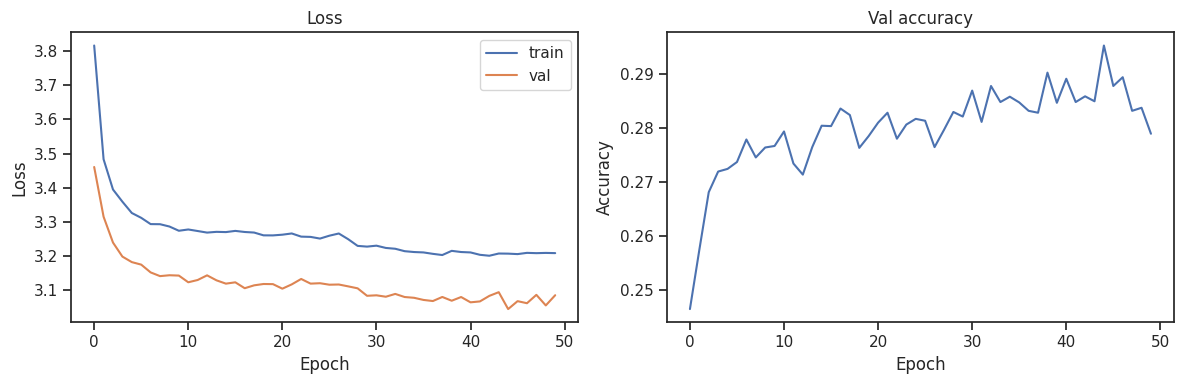

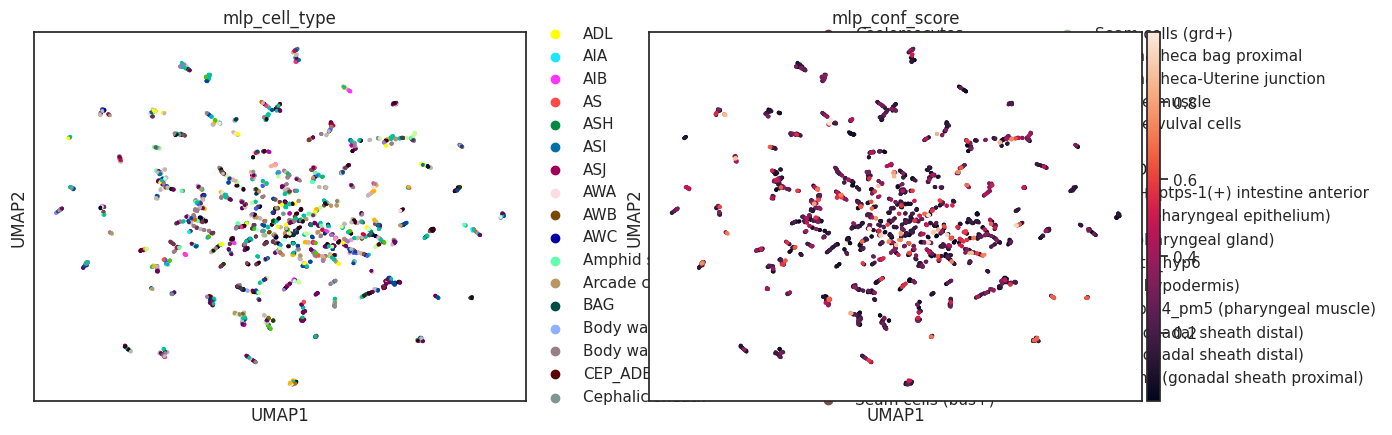

In [65]:
shared_genes = list(set(rna_ad.var_names) & set(ref_ad.var_names))

model, le, history = train_model(
    ref_ad,
    label_col="assigned_cell_type",
    shared_genes=shared_genes,
    
    hidden_dims=[256, 128],   # smaller network — fewer params to overfit
    dropout_p=0.5,            # more aggressive model dropout
    n_epochs=50,
    batch_size=256,
    lr=1e-3,
    weight_decay=1e-3,
)

rna_ad = predict_cell_types(model, le, rna_ad, shared_genes)

# check confidence distribution
print(rna_ad.obs["mlp_conf_score"].describe())

plot_training_history(history)

sc.pl.umap(rna_ad, color=["mlp_cell_type", "mlp_conf_score"])


# scTypist classifier

https://www.celltypist.org/

https://github.com/Teichlab/celltypist?tab=readme-ov-file

In [ ]:
import celltypist

# Ingest with with WormSeq atlas

* Doesn't work

### Load wormseq reference

In [19]:
# ref_ad = sc.read_h5ad('../data/reference/Ghaddar2023/cds_baseline_post_sub.h5ad')
ref_ad = sc.read_h5ad('../data/reference/Ghaddar2023/cds_baseline_with_counts.h5ad')

In [20]:
var_names = ref_ad.var_names.intersection(rna_ad.var_names)
ref_ad = ref_ad[:, var_names].copy()
rna_ad = rna_ad[:, var_names].copy()

### Downsample WormSeq

* downsample to 0.25 of each cluster

In [21]:
def downsample_cells_per_group(adata, groupby, max_cells_per_group=None, fraction=None, random_state=42):
    """
    Downsample cells within each group to balance uneven cell type/sample proportions.

    Parameters
    ----------
    adata : AnnData
    groupby : str
        Key in `adata.obs` to group by (e.g. 'cell_type', 'sample').
    max_cells_per_group : int, optional
        Maximum cells to retain per group. Groups smaller than this are left intact.
    fraction : float, optional
        Fraction of cells per group to retain (0 < fraction <= 1).
    random_state : int

    Returns
    -------
    AnnData
        Downsampled AnnData.
    """
    if max_cells_per_group is None and fraction is None:
        raise ValueError("Specify either `max_cells_per_group` or `fraction`.")
    if max_cells_per_group is not None and fraction is not None:
        raise ValueError("`max_cells_per_group` and `fraction` are mutually exclusive.")

    rng = np.random.default_rng(random_state)
    group_labels = adata.obs[groupby].values
    keep_indices = []

    for group in np.unique(group_labels):
        group_idx = np.where(group_labels == group)[0]
        n_group = len(group_idx)

        if max_cells_per_group is not None:
            n_keep = min(max_cells_per_group, n_group)  # small groups untouched
        else:
            n_keep = int(np.floor(n_group * fraction))

        sampled = rng.choice(group_idx, size=n_keep, replace=False)
        keep_indices.append(sampled)

    keep_indices = np.sort(np.concatenate(keep_indices))
    return adata[keep_indices].copy()

In [22]:
ref_ad = downsample_cells_per_group(ref_ad, groupby='assigned_cell_type', max_cells_per_group=50)
ref_ad

AnnData object with n_obs × n_vars = 8547 × 1185
    obs: 'cell', 'n.umi', 'umi.quant', 'condition', 'channel', 'Size_Factor', 'num_genes_expressed', 'bg.counts.YA.C.loadings', 'bg.counts.YA.F.loadings', 'sample', 'bg.counts.YA.C.1', 'bg.counts.YA.C.2', 'bg.counts.YA.C.3', 'bg.counts.YA.F.1', 'bg.counts.YA.F.2', 'bg.counts.YA.F.3', 'cluster', 'assigned_cell_type', 'cell_type_group'
    var: 'id', 'gene_short_name', 'num_cells_expressed', 'use_for_ordering'
    uns: 'X_name', 'cds_version', 'citations'
    obsm: 'Aligned', 'PCA', 'UMAP'
    layers: 'counts'

### Process Ref

In [25]:
sc.pp.pca(ref_ad)
sc.pp.neighbors(ref_ad)
sc.tl.umap(ref_ad)

### Ingest

In [26]:
sc.tl.ingest(rna_ad, ref_ad, obs="assigned_cell_type")

/home/dmullane/micromamba/envs/scvi-env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [28]:
adata = ad.concat([ref_ad, rna_ad], label="Dataset", keys=["WormSeq", "CapGTA"])
adata

AnnData object with n_obs × n_vars = 12547 × 1185
    obs: 'assigned_cell_type', 'Dataset'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

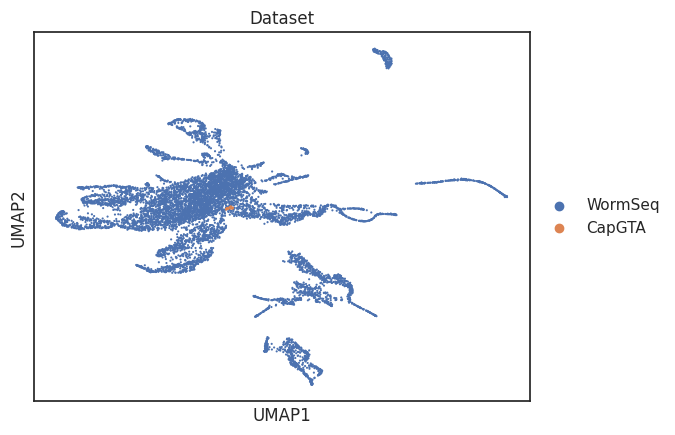

In [29]:
sc.pl.umap(adata, color="Dataset")

# BBKNN integration with WormSeq atlas

# MNN integration with WormSeq atlas

`scanpy.external.pp.mnn_correct`

# Harmony integration with WormSeq atlas

`scanpy.external.pp.harmony_integrate`

# Scanorama integration with WormSeq atlas

`scanpy.external.pp.scanorama_integrate`

# `scVI` integration with WormSeq atlas
* Questionable

### Reload CapGTA

In [2]:
csvs = {
    'UDI_5':'../results/worm_CapGTA_UDI_5/rna_counts_matrix.csv',
    'UDI_6':'../results/worm_CapGTA_UDI_5/rna_counts_matrix.csv',
    'UDI_7':'../results/worm_CapGTA_UDI_5/rna_counts_matrix.csv',
    'UDI_8':'../results/worm_CapGTA_UDI_5/rna_counts_matrix.csv',
}

adatas = []

for batch_id,csv in csvs.items():
    df = pd.read_csv(csv, index_col=0)

    # AnnData expects cells x genes, so transpose
    adata = ad.AnnData(X=df.T.values)
    adata.obs_names = [f"{bc}_{batch_id}" for bc in df.columns]   # cell barcodes
    adata.var_names = df.index.tolist()
    adata.obs['UDI'] = batch_id

    adatas.append(adata)
    
rna_ad = ad.concat(adatas)

# print(f"before normalization min: {rna_ad.X.min()}")
# print(f"before normalization max: {rna_ad.X.max()}")
      
# gene_len = pd.read_csv('../data/reference/gene_lengths.csv', index_col=0)

# gene_len = gene_len.reindex(rna_ad.var.index).dropna()
# rna_ad = rna_ad[:, gene_len.index]
# assert (rna_ad.var.index == gene_len.index).sum() == rna_ad.shape[1]
# rna_ad.X = (rna_ad.X / gene_len['exonic_length'].values) * np.median(gene_len['exonic_length'].values)
# # round to integer
# rna_ad.X = np.rint(rna_ad.X)

# print(f"after normalization min: {rna_ad.X.min()}")
# print(f"after normalization max: {rna_ad.X.max()}")

rna_ad.layers["counts"] = rna_ad.X.copy()
rna_ad

AnnData object with n_obs × n_vars = 4000 × 46748
    obs: 'UDI'
    layers: 'counts'

### Load wormseq reference

In [3]:
# ref_ad = sc.read_h5ad('../data/reference/Ghaddar2023/cds_baseline_post_sub.h5ad')
ref_ad = sc.read_h5ad('../data/reference/Ghaddar2023/cds_baseline_with_counts.h5ad')

In [4]:
var_names = ref_ad.var_names.intersection(rna_ad.var_names)
ref_ad = ref_ad[:, var_names].copy()
rna_ad = rna_ad[:, var_names].copy()

### Downsample WormSeq

* downsample to 0.25 of each cluster

In [5]:
def downsample_cells_per_group(adata, groupby, max_cells_per_group=None, fraction=None, random_state=42):
    """
    Downsample cells within each group to balance uneven cell type/sample proportions.

    Parameters
    ----------
    adata : AnnData
    groupby : str
        Key in `adata.obs` to group by (e.g. 'cell_type', 'sample').
    max_cells_per_group : int, optional
        Maximum cells to retain per group. Groups smaller than this are left intact.
    fraction : float, optional
        Fraction of cells per group to retain (0 < fraction <= 1).
    random_state : int

    Returns
    -------
    AnnData
        Downsampled AnnData.
    """
    if max_cells_per_group is None and fraction is None:
        raise ValueError("Specify either `max_cells_per_group` or `fraction`.")
    if max_cells_per_group is not None and fraction is not None:
        raise ValueError("`max_cells_per_group` and `fraction` are mutually exclusive.")

    rng = np.random.default_rng(random_state)
    group_labels = adata.obs[groupby].values
    keep_indices = []

    for group in np.unique(group_labels):
        group_idx = np.where(group_labels == group)[0]
        n_group = len(group_idx)

        if max_cells_per_group is not None:
            n_keep = min(max_cells_per_group, n_group)  # small groups untouched
        else:
            n_keep = int(np.floor(n_group * fraction))

        sampled = rng.choice(group_idx, size=n_keep, replace=False)
        keep_indices.append(sampled)

    keep_indices = np.sort(np.concatenate(keep_indices))
    return adata[keep_indices].copy()

In [6]:
ref_ad = downsample_cells_per_group(ref_ad, groupby='assigned_cell_type', max_cells_per_group=50)
ref_ad.X = ref_ad.layers["counts"]

### Concatenate

In [7]:
adata = ad.concat([ref_ad, rna_ad], label="Dataset", keys=["WormSeq", "CapGTA"])
adata

AnnData object with n_obs × n_vars = 12547 × 20137
    obs: 'Dataset'
    layers: 'counts'

In [8]:
print(f"X min: {adata.X.min()}")
print(f"X max: {adata.X.max()}")

X min: 0.0
X max: 22862.0


### Select Highly Variable Features 

In [9]:
scvi.data.poisson_gene_selection(adata, n_top_genes=2000)
adata.var.head()

Sampling from binomial...: 100%|██████████| 10000/10000 [00:00<00:00, 18357.51it/s]


,highly_variable,observed_fraction_zeros,expected_fraction_zeros,prob_zero_enriched_nbatches,prob_zero_enrichment,prob_zero_enrichment_rank
WBGene00010957,True,0.323822,0.000233,1,0.3191,19753.0
WBGene00010958,True,0.404718,0.269197,1,0.2919,19670.0
WBGene00010959,True,0.392843,0.210065,1,0.3150,19743.0
WBGene00010960,True,0.322388,0.002262,1,0.3251,19776.0
WBGene00010961,True,0.602295,0.563935,1,0.2622,19562.0


In [10]:
adata = adata[:, adata.var["highly_variable"]].copy()
adata

AnnData object with n_obs × n_vars = 12547 × 2000
    obs: 'Dataset'
    var: 'highly_variable', 'observed_fraction_zeros', 'expected_fraction_zeros', 'prob_zero_enriched_nbatches', 'prob_zero_enrichment', 'prob_zero_enrichment_rank'
    uns: 'hvg'
    layers: 'counts'

### Setup and train scVI model

In [11]:
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="Dataset")

In [12]:
scvi_model = scvi.model.SCVI(adata,
                             n_layers=2,
                             n_hidden=128,
                             n_latent=30,
                             dropout_rate=0.1
                            )

In [13]:
scvi_model.train(check_val_every_n_epoch=1,
                 max_epochs=120,
                 early_stopping=True,
                 early_stopping_patience=10,
                 early_stopping_monitor="elbo_validation"
                )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/home/dmullane/micromamba/envs/scvi-env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/home/dmullane/micromamba/envs/scvi-env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argumen

Epoch 120/120: 100%|██████████| 120/120 [02:17<00:00,  1.15s/it, v_num=1, train_loss=746]

`Trainer.fit` stopped: `max_epochs=120` reached.


Epoch 120/120: 100%|██████████| 120/120 [02:17<00:00,  1.15s/it, v_num=1, train_loss=746]


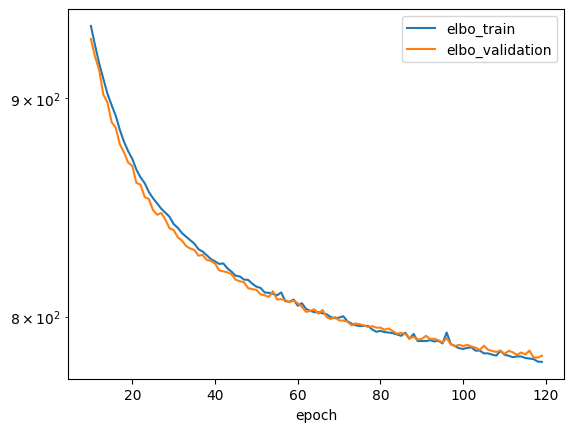

In [14]:
# Ensure convergence
train_test_results = scvi_model.history["elbo_train"]
train_test_results["elbo_validation"] = scvi_model.history["elbo_validation"]
train_test_results.iloc[10:].plot(logy=True)  # exclude first 10 epochs
plt.show()

### Inspect Latent Space

In [15]:
SCVI_LATENT_KEY = "X_scVI"
adata.obsm[SCVI_LATENT_KEY] = scvi_model.get_latent_representation()

In [16]:
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)
sc.tl.umap(adata)

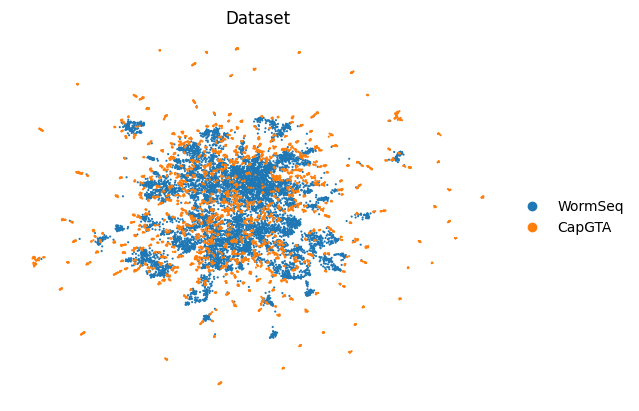

In [17]:
sc.pl.umap(
    adata,
    color=["Dataset"],
    frameon=False,
    ncols=1,
)

### Label Transfer

In [48]:
SCANVI_CELLTYPE_KEY = "celltype_scanvi"

adata.obs[SCANVI_CELLTYPE_KEY] = "Unknown"
WormSeq_mask = adata.obs["Dataset"] == "WormSeq"
adata.obs[SCANVI_CELLTYPE_KEY][WormSeq_mask] = ref_ad.obs.assigned_cell_type[WormSeq_mask].values

/loc/scratch/47826056/ipykernel_13736/1251598716.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adata.obs[SCANVI_CELLTYPE_KEY][WormSeq_mask] = ref_ad.obs.assigned_cell_type[WormSeq_mask].values
/loc/scratch/47826056/ipykernel_13736/1251

In [49]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    scvi_model,
    adata=adata,
    unlabeled_category="Unknown",
    labels_key=SCANVI_CELLTYPE_KEY,
)

In [50]:
scanvi_model.train(max_epochs=20, n_samples_per_label=10)

INFO     Training for 20 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/home/dmullane/micromamba/envs/scvi-env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch 20/20: 100%|██████████| 20/20 [00:53<00:00,  2.66s/it, v_num=1, train_loss=279]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [00:53<00:00,  2.68s/it, v_num=1, train_loss=279]


In [51]:
SCANVI_LATENT_KEY = "X_scANVI"
SCANVI_PREDICTION_KEY = "C_scANVI"

adata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(adata)
adata.obs[SCANVI_PREDICTION_KEY] = scanvi_model.predict(adata)

In [52]:
sc.pp.neighbors(adata, use_rep=SCANVI_LATENT_KEY)
sc.tl.umap(adata)

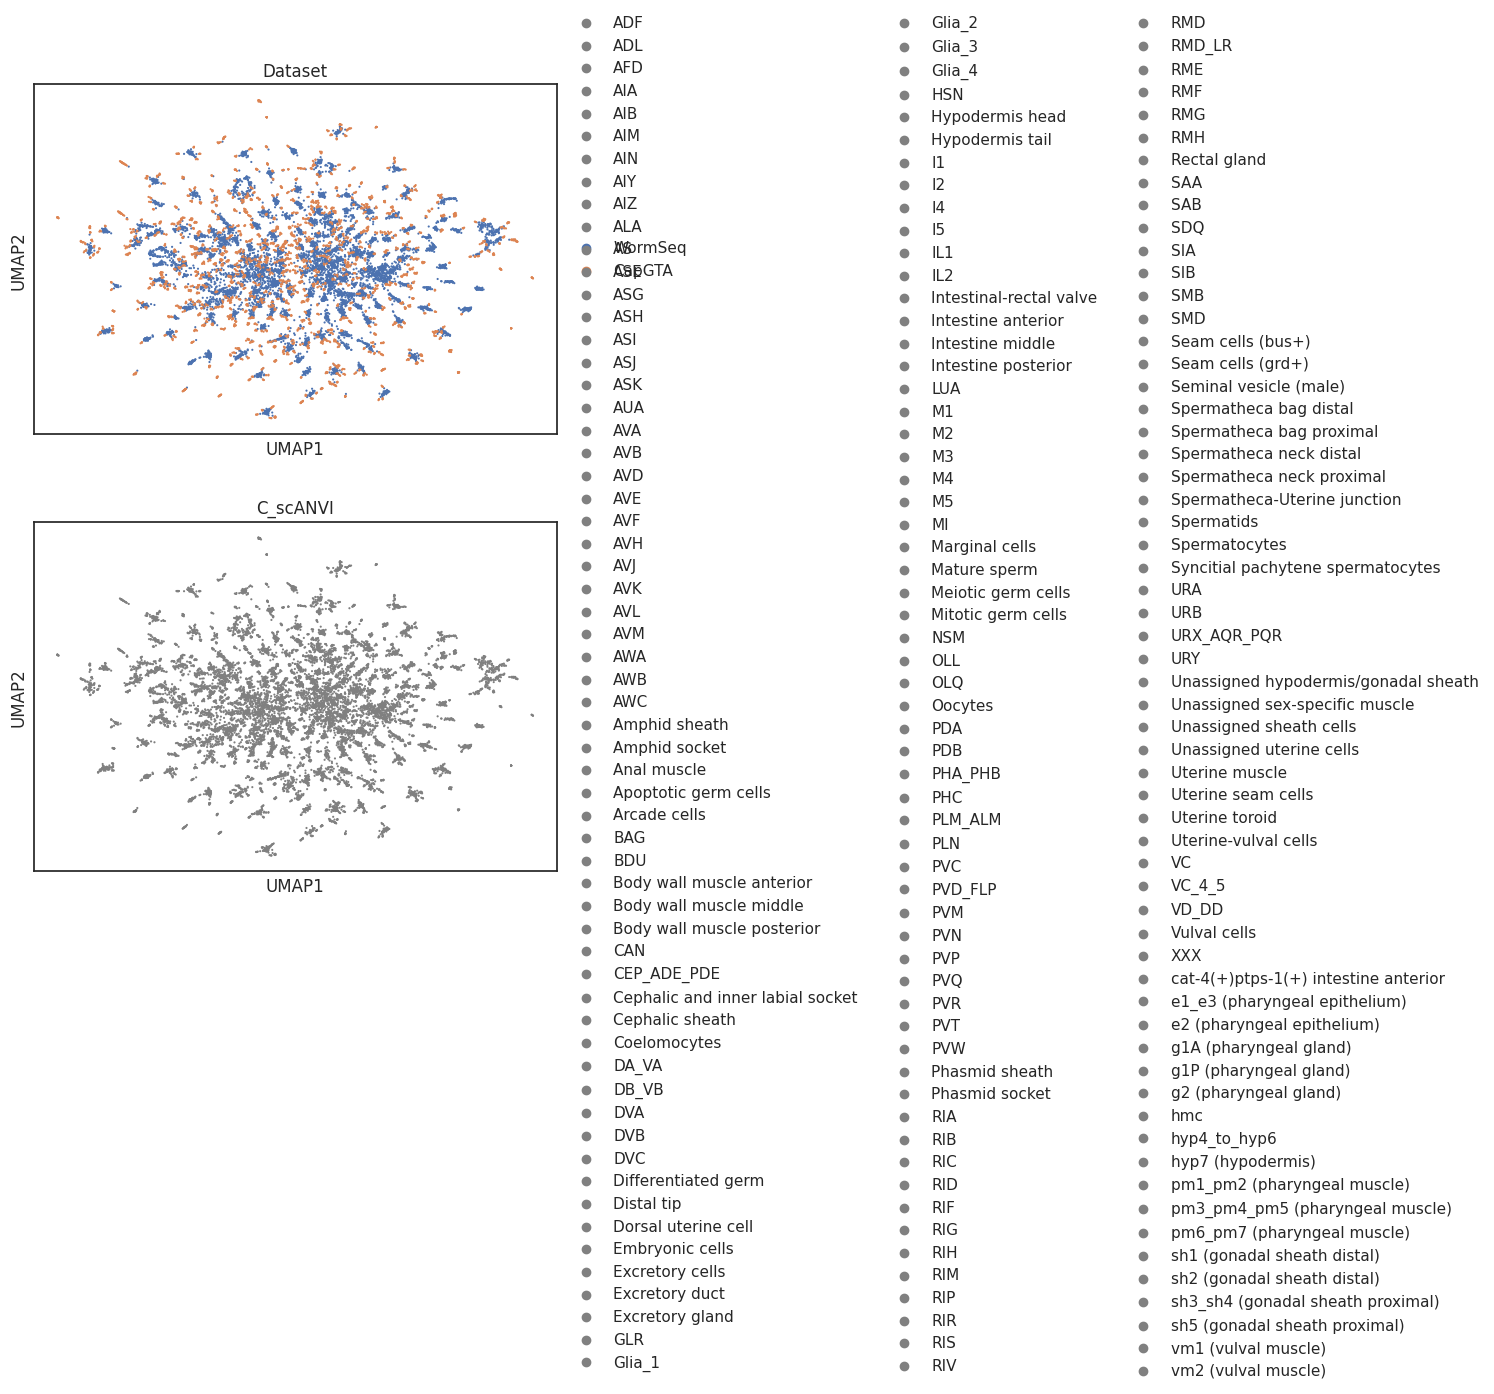

In [53]:
sc.pl.umap(
    adata,
    color=["Dataset", SCANVI_PREDICTION_KEY],
    ncols=1,
)